# Методы оптимизации
## Лабораторная работа 2: Продвинутые методы безусловной оптимизации


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.sparse import diags
from sklearn.datasets import load_svmlight_file

from optimization import conjugate_gradients, hessian_free_newton, lbfgs, gradient_descent
from oracles import QuadraticOracle, create_log_reg_oracle, hess_vec_finite_diff

sns.set_theme()

np.random.seed(0)

datasets_path = './datasets/'

In [23]:
# Эксперимент подсчета кол-ва итераций в зависимости от числа обусловленности и размерности
def get_iter_of_cond_df(display=False):
  df = pd.DataFrame(data={'dimension': [], 'iterations': [], 'condition': []})
  n = np.array([10**i for i in range(1,5)], dtype=np.int_)
  k = np.arange(1, 500, 10)
  iterations = []

  for ni in n:
      x0 = np.random.randn(ni)
      for ki in k:
          ki_iterations = []
          for _ in range(5):
              if ki != 1:
                  diagonal = np.random.randint(1, ki, (ni, )) + np.random.random((ni, ))
                  diagonal[0] = 1
                  diagonal[-1] = ki
                  A = diags(diagonal, 0)
              else:
                  A = np.eye(ni)
              b = np.random.randint(-10, 10, size=(ni,))

              matvec = (lambda x: A.dot(x))
              x_opt, message, history = conjugate_gradients(matvec, b, x0, tolerance=1e-4, max_iter=100, trace=True, display=display)
              ki_iterations.append(len(history['time']))

          dfi = pd.DataFrame(data={'dimension': ni,
                                  'iterations': ki_iterations,
                                  'condition': ki})
          df = pd.concat([df, dfi], axis=0)
    
  return df


# Эксперимент выбора размера истории в методе L-BFGS
def get_opt_history_on_real_data(file_name):
    print(f'{get_opt_history_on_real_data.__name__}: function started...')
    df = pd.DataFrame(data={'memory_size': [], 
                            'history': [], 
                            'grad_norm_ratio': []})


    print(f"{get_opt_history_on_real_data.__name__}: '{file_name}' is proceeding...")
    X, y = load_svmlight_file(file_name)
    x0 = np.zeros(X.shape[1])
    regcoef = 1 / X.shape[0]
    oracle = create_log_reg_oracle(X, y, regcoef, oracle_type='usual')
    memory_size = [0, 1, 5, 10, 50, 100]
    
    grad_norm_x0 = np.linalg.norm(oracle.grad(x0))

    for i, ms in enumerate(memory_size):
        x, message, history = lbfgs(oracle, x0, memory_size=ms, display=False, trace=True)
        dfi = pd.DataFrame(data={'memory_size': ms,
                                 'history': history['time'],
                                 'grad_norm_ratio': np.array(history['grad_norm'])**2 / grad_norm_x0**2})

        df = pd.concat([df, dfi], axis=0)
    
    return df

# Эксперимент cравнение методов на реальной задаче логистической регрессии
def get_opt_history_on_real_data(file_name, method='GD'):
  print(f'{get_opt_history_on_real_data.__name__}: function started...')
  methods = {'GD': gradient_descent, 'HFN': hessian_free_newton, 'LBFGS': lbfgs}

  print(f"{get_opt_history_on_real_data.__name__}: '{file_name}' is proceeding...")
  X, y = load_svmlight_file(file_name)
  regcoef = 1 / X.shape[0]
  w0_point = np.zeros(X.shape[1])
  oracle = create_log_reg_oracle(X, y, regcoef, oracle_type='usual')

  w_opt, _, history = methods[method](oracle, w0_point, trace=True)

  return oracle, w0_point, w_opt, history


# Функция для отрисовки изменения значения функции во времени
def plot_func_value_at_time(oracles, history, labels, w0_point, dataset_name):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True);
  fig.suptitle(f'Минимизация функции потерь логистической функции \n датасет {dataset_name}')

  for i in range(len(history)):
    axes[0].plot(range(len(history[i]['time'])), history[i]['func'], label=labels[i])
    axes[0].set_xlabel('Число итераций')
    axes[0].set_ylabel('f(x)')
    axes[0].legend()

  for i in range(len(history)):
    axes[1].plot(history[i]['time'], history[i]['func'], label=labels[i])
    axes[1].set_xlabel('Время, с')
    axes[1].set_ylabel('f(x)')
    axes[1].legend()

  for i in range(len(history)):
    grads_history = np.array(history[i]['grad_norm'])
    init_grad = np.linalg.norm(oracles[i].grad(w0_point))
    axes[2].plot(history[i]['time'], np.log(grads_history**2 / init_grad**2), label=labels[i])
    axes[2].set_xlabel('Время, с')
    axes[2].set_ylabel('$log(|∇f(x)|^2/|∇f(x_0)|^2)$')
    axes[2].legend()

## 1. Основные задачи

1. Реализовать классы линейного поиска (см. файл `utils.py`) и оракула логистической регрессии (см. файл `oracles.py`)
2. Реализовать метод сопряженных градиентов для решения системы линейных уравнений \
Проверка работы

In [4]:
A = np.array([[0, 1], [1, 0]])
b = np.array([2, 3])

matvec = (lambda x: A.dot(x))

conjugate_gradients(matvec, b, np.random.randn(2), tolerance=1e-4, max_iter=100)

(array([3., 2.]), 'success', None)

3. Для оракула логистической регрессии (см. файл `oracles.py`) реализуйте метод `hess_vec`, выполняющий умножение гессиана на заданный вектор.
4. Реализуйте подсчет разностной аппроксимации произведения гессиана на заданный вектор.\
C помощью реализованной процедуры проверьте правильность реализации метода hess_vec логистического оракула. Для этого сгенерируйте небольшую модельную выборку и сравните значения, выдаваемые методом hess_vec, с соответствующими разностными аппроксимациями в нескольких пробных
точках

In [5]:
n = 100
regcoef = 0.001

x1 = np.random.normal(0, 1, (n, 2))
b1 = np.ones(n)

x2 = np.random.normal(5, 2, (n, 2))
b2 = (-1) * np.ones(n)

A = np.vstack([x1, x2])
b = np.hstack([b1, b2])

oracle = create_log_reg_oracle(A, b, regcoef, oracle_type='usual')

In [15]:
x_points = np.random.rand(10,2) * np.random.randint(1, 10, size=(10, 2))
v_points = np.random.rand(10,2) * np.random.randint(1, 10, size=(10, 2))

hess_vecs = pd.DataFrame({'x':[], 'v':[],
                          'hess_vec':[],
                          'hess_vec_finite_diff':[]})
for x, v in zip(x_points, v_points):
    hess_vec_output = oracle.hess_vec(x, v)
    hess_vec_finite_diff_output = hess_vec_finite_diff(oracle.func, x, v)
    temp = pd.DataFrame({'x': x, 'v': v,
                          'hess_vec': hess_vec_output.toarray()[0],
                          'hess_vec_finite_diff': hess_vec_finite_diff_output,
                          'residual': round(np.linalg.norm(hess_vec_finite_diff_output - hess_vec_output, 2), 5)})
    hess_vecs = pd.concat([hess_vecs, temp])

In [16]:
hess_vecs

,x,v,hess_vec,hess_vec_finite_diff,residual
0,2.398873,3.358944,0.086223,0.086295,0.00008
1,5.371068,1.337183,-0.028491,-0.028457,0.00008
0,1.378873,0.483192,0.020168,0.020233,0.00007
1,3.568834,0.170622,-0.005059,-0.005045,0.00007
0,5.113495,1.771172,0.015869,0.015881,0.00004
1,2.794128,0.300042,-0.015133,-0.015170,0.00004
0,3.454081,0.530079,0.011193,0.011138,0.00007
1,2.458111,0.066149,-0.008590,-0.008633,0.00007
0,0.490295,0.131210,0.001303,0.001297,0.00001
1,3.289627,0.856276,0.010275,0.010267,0.00001


3. Реализуйте усеченный метод Ньютона \
Проверка работы

In [27]:
A = np.array([[0, 1], [1, 0]])
b = np.array([2, 3])

oracle = QuadraticOracle(A, b)

In [28]:
hessian_free_newton(oracle, np.random.randn(2), tolerance=1e-4)

(array([3., 2.]), 'success', None)

4. Реализуйте метод LBFGS \
Проверка работы

In [8]:
A = np.array([[0, 1], [1, 0]])
b = np.array([2, 3])

oracle = QuadraticOracle(A, b)

In [16]:
lbfgs(oracle, np.random.randn(2), tolerance=1e-4)

(array([nan, nan]), 'iterations_exceeded', None)

## 2. Эксперименты

### 2.1. Зависимость числа итераций метода сопряженных градиентов от числа обусловленности и размерности пространства

In [66]:
df = get_iter_of_cond_df(display=False)

C:\Users\kshch\AppData\Local\Temp\ipykernel_16040\267259044.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(ax=ax, x="condition", y="iterations", hue='dimension', palette=sns.color_palette(), data=df_const);


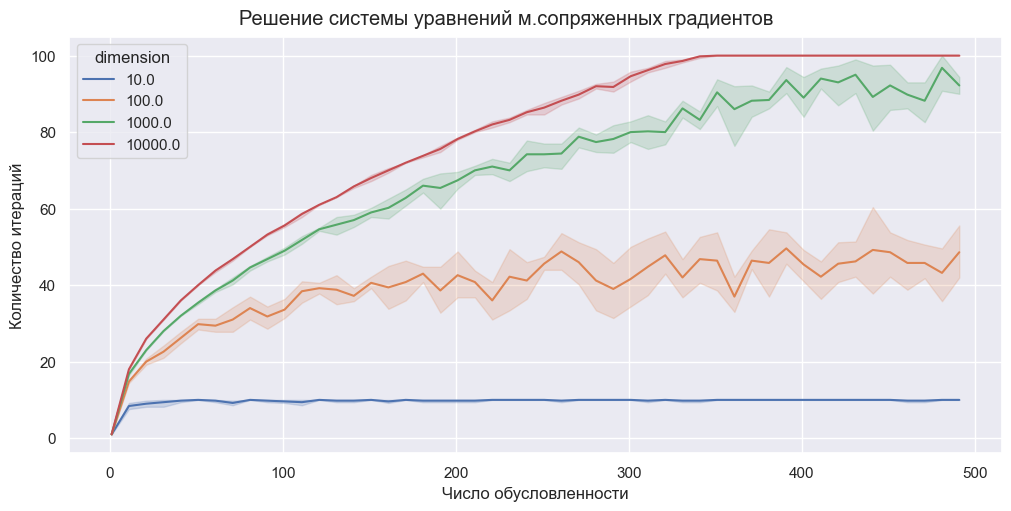

In [94]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True);
fig.suptitle('Решение системы уравнений м.сопряженных градиентов');

sns.lineplot(ax=ax, x="condition", y="iterations", hue='dimension', palette=sns.color_palette(), data=df);

ax.set_xlabel('Число обусловленности');
ax.set_ylabel('Количество итераций');

### 2.2. Выбор размера истории в методе L-BFGS

In [41]:
df = get_opt_history_on_real_data(datasets_path + 'news20.binary.bz2')

get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './news20.binary.bz2' is proceeding...


c:\Users\kshch\Projects\Методы_оптимизации\ИТМО\Лабораторные\work2\venv\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\kshch\Projects\Методы_оптимизации\ИТМО\Лабораторные\work2\utils.py:90: LineSearchWarning: The line search algorithm did not converge
  alpha_k = line_search(oracle.func, oracle.grad,


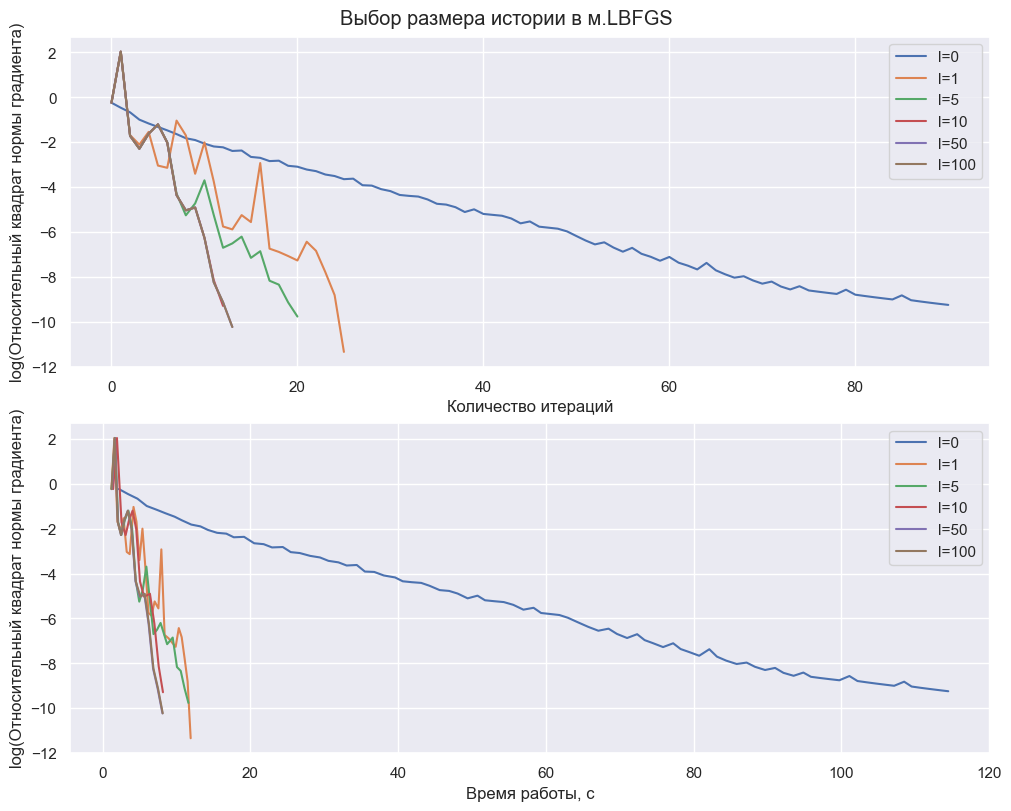

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True);
fig.suptitle('Выбор размера истории в м.LBFGS');

memory_size = sorted(list(set(df['memory_size'])))
for ms in memory_size:
    data = df[df['memory_size'] == ms]
    ax[0].plot(range(len(data['history'])), np.log(data['grad_norm_ratio']), label=f'l={int(ms)}')
    ax[1].plot(data['history'], np.log(data['grad_norm_ratio']), label=f'l={int(ms)}')

ax[0].set_xlabel('Количество итераций');
ax[0].set_ylabel('log(Относительный квадрат нормы градиента)');
ax[0].legend();

ax[1].set_xlabel('Время работы, c');
ax[1].set_ylabel('log(Относительный квадрат нормы градиента)');
ax[1].legend();

fig.savefig('./lbfgs')

### 2.3. Сравнение методов на реальной задаче логистической регрессии

In [27]:
file_names = [ 'w8a.txt', 'gisette_scale.bz2', 'real-sim.bz2', 'news20.binary.bz2', 'rcv1_train.binary.bz2']
file_paths = [datasets_path + file_name for file_name in file_names]
labels = ['Gradient descent', 'Hessian Free Newton', 'LBFGS']

In [28]:
GD_oracle, w0_point, _, GD_history = get_opt_history_on_real_data(file_paths[0], method='GD')
HFN_oracle, w0_point, _, HFN_history = get_opt_history_on_real_data(file_paths[0], method='HFN')
LBFGS_oracle, w0_point, _, LBFGS_history = get_opt_history_on_real_data(file_paths[0], method='LBFGS')
oracles = [GD_oracle, HFN_oracle, LBFGS_oracle]
history = [GD_history, HFN_history, LBFGS_history]

get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/w8a.txt' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/w8a.txt' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/w8a.txt' is proceeding...


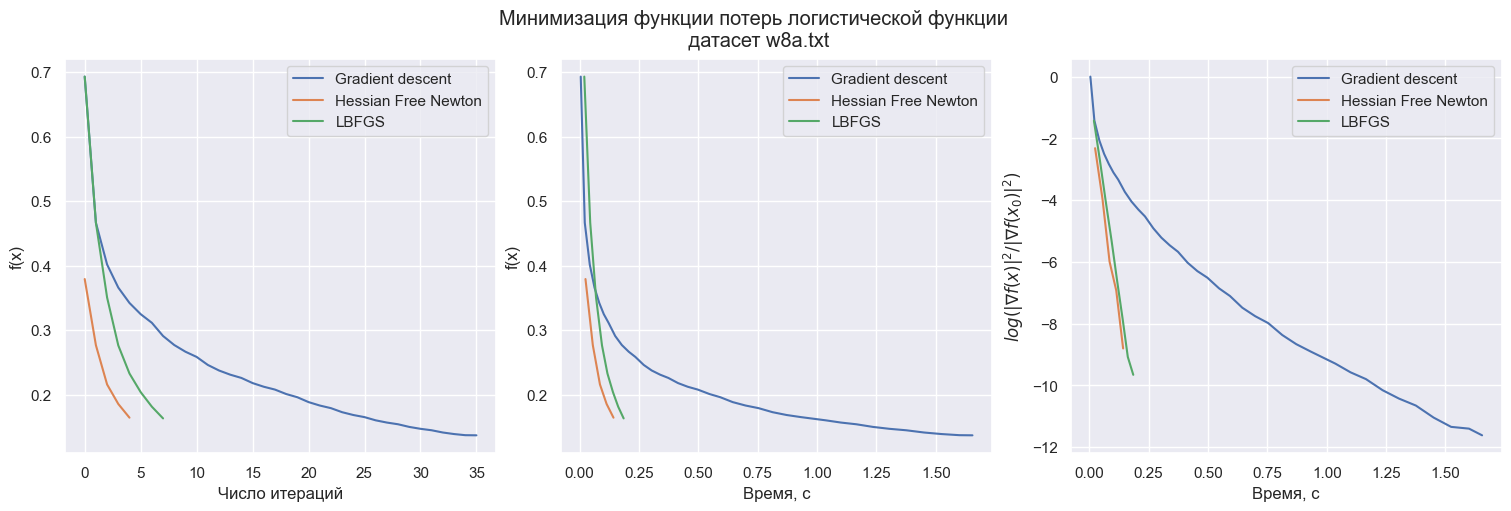

In [29]:
plot_func_value_at_time(oracles, history, labels, w0_point, file_names[0])

In [30]:
GD_oracle, w0_point, _, GD_history = get_opt_history_on_real_data(file_paths[1], method='GD')
HFN_oracle, w0_point, _, HFN_history = get_opt_history_on_real_data(file_paths[1], method='HFN')
LBFGS_oracle, w0_point, _, LBFGS_history = get_opt_history_on_real_data(file_paths[1], method='LBFGS')
oracles = [GD_oracle, HFN_oracle, LBFGS_oracle]
history = [GD_history, HFN_history, LBFGS_history]

get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/gisette_scale.bz2' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/gisette_scale.bz2' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/gisette_scale.bz2' is proceeding...


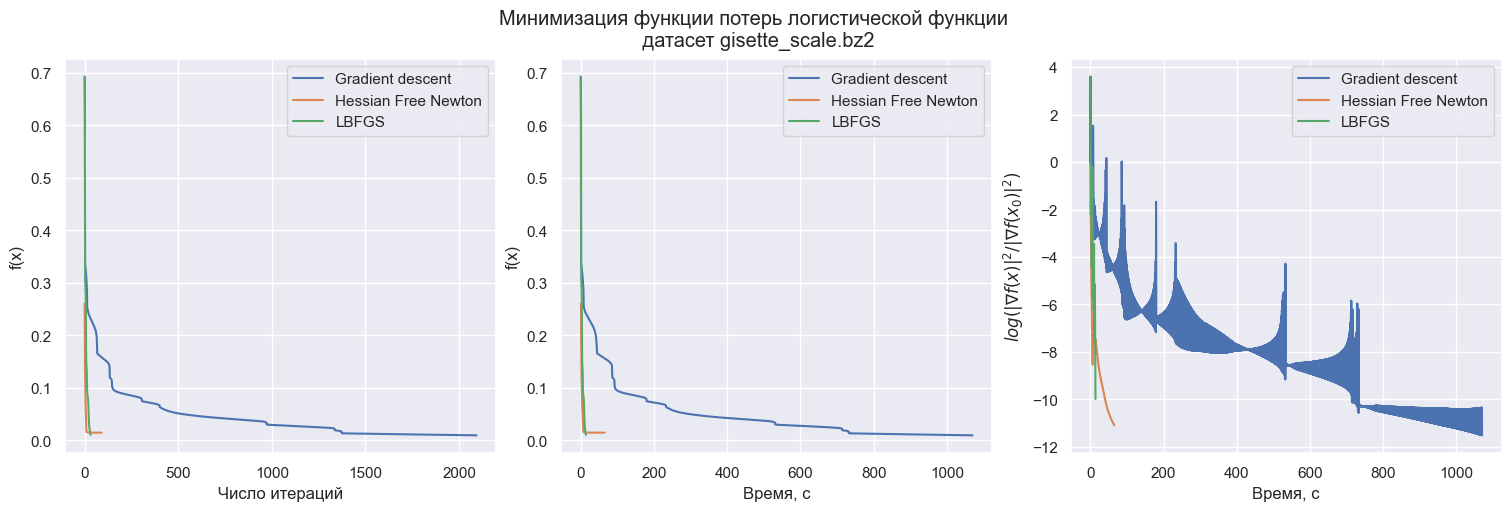

In [31]:
plot_func_value_at_time(oracles, history, labels, w0_point, file_names[1])

In [32]:
GD_oracle, w0_point, _, GD_history = get_opt_history_on_real_data(file_paths[2], method='GD')
HFN_oracle, w0_point, _, HFN_history = get_opt_history_on_real_data(file_paths[2], method='HFN')
LBFGS_oracle, w0_point, _, LBFGS_history = get_opt_history_on_real_data(file_paths[2], method='LBFGS')
oracles = [GD_oracle, HFN_oracle, LBFGS_oracle]
history = [GD_history, HFN_history, LBFGS_history]


get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/real-sim.bz2' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/real-sim.bz2' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/real-sim.bz2' is proceeding...


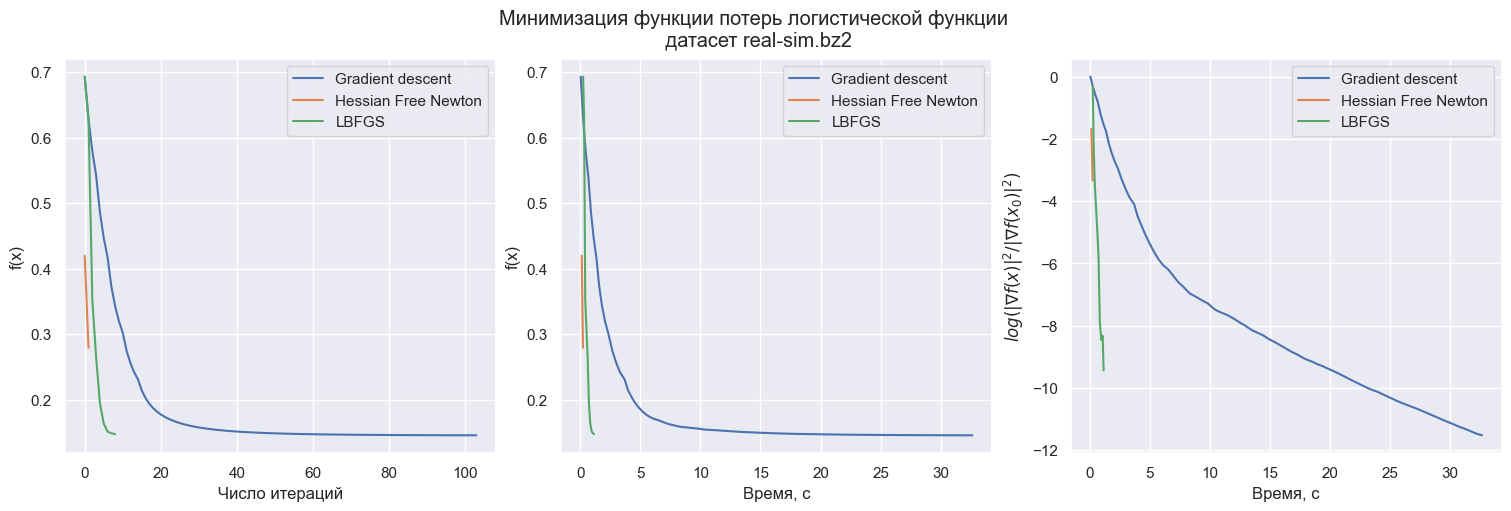

In [33]:
plot_func_value_at_time(oracles, history, labels, w0_point, file_names[2])

In [34]:
GD_oracle, w0_point, _, GD_history = get_opt_history_on_real_data(file_paths[3], method='GD')
HFN_oracle, w0_point, _, HFN_history = get_opt_history_on_real_data(file_paths[3], method='HFN')
LBFGS_oracle, w0_point, _, LBFGS_history = get_opt_history_on_real_data(file_paths[3], method='LBFGS')
oracles = [GD_oracle, HFN_oracle, LBFGS_oracle]
history = [GD_history, HFN_history, LBFGS_history]

get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/news20.binary.bz2' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/news20.binary.bz2' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/news20.binary.bz2' is proceeding...


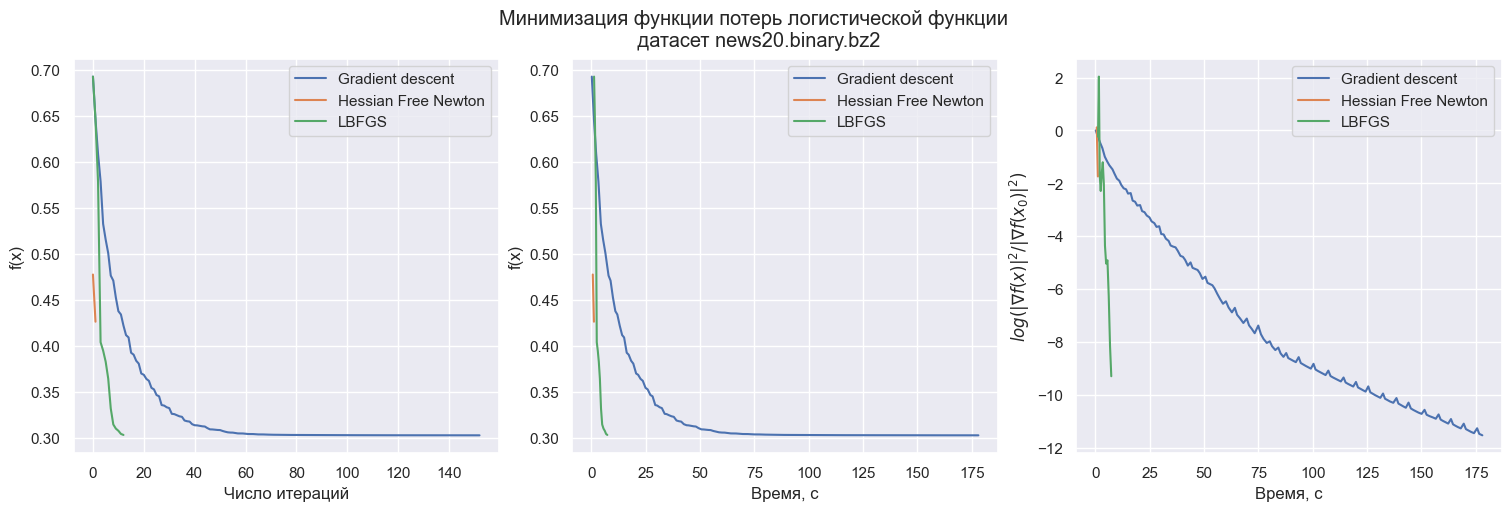

In [35]:
plot_func_value_at_time(oracles, history, labels, w0_point, file_names[3])

In [36]:
GD_oracle, w0_point, _, GD_history = get_opt_history_on_real_data(file_paths[4], method='GD')
HFN_oracle, w0_point, _, HFN_history = get_opt_history_on_real_data(file_paths[4], method='HFN')
LBFGS_oracle, w0_point, _, LBFGS_history = get_opt_history_on_real_data(file_paths[4], method='LBFGS')
oracles = [GD_oracle, HFN_oracle, LBFGS_oracle]
history = [GD_history, HFN_history, LBFGS_history]

get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/rcv1_train.binary.bz2' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/rcv1_train.binary.bz2' is proceeding...
get_opt_history_on_real_data: function started...
get_opt_history_on_real_data: './datasets/rcv1_train.binary.bz2' is proceeding...


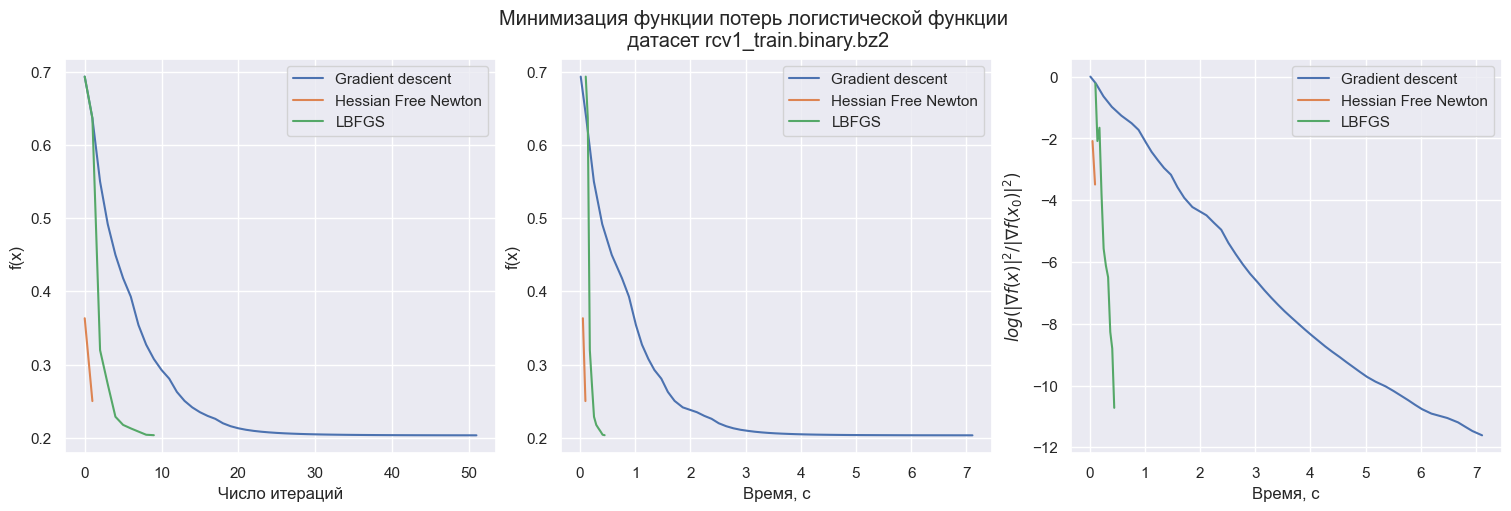

In [37]:
plot_func_value_at_time(oracles, history, labels, w0_point, file_names[4])